In [12]:
####### 
# This cell is meant to install packages if some are missing
#######

# !pip install tqdm scipy
# !pip install matplotlib
# !pip install opencv-contrib-python
# !pip install numpy
# !pip install --upgrade tdmclient

In [1]:
DEBUG = True


import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
import Motion_control as mc
import local_nav as ln

#import computer_vision
from djikstra import djikstra_algo,create_plot
from calibration import data

### Connect the thymio(the speed set to 0 is here in case of an error during calibration or during the code)
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())


#we initialize the calibration calss aswell as some values that are needed throughout the entire code
Ts = 0.01
SPEED_X = 101
SPEED_Y = 100
GND_THRESHOLD = 400
CELL_WIDTH = 62.5

cal_data = data(Ts, SPEED_X, SPEED_Y, GND_THRESHOLD, client, node)
mc.motors(node, 0, 0)

# Calibration

In this section, we will run multiple functions, in order to calibrate our thymio to the current environement. This gives us more flexibility, and makes it easier to use different thymio in different environment.

### Calibration of the thymio 

In this first step, we will use the following image to calibrate the speed, its conversion ratio from the thymio's sensor to mm/s, and its variance for the Kalman filter.
<!-- ![localisation map](Pictures/Picture3.jpg) -->
<img src="Pictures/Picture1.jpg" width="900"/>

In this next function, we will ask the thymio to move forward, at a known speed. As soon as its ground sensor detect it is on the black line, it will start a timer. When it exit the line, the timer will stop, the thymio will stop aswell, and all the desired values will be computed. In this function, the line length is know and we need to be careful to properly align the thymio as to make it follow the line. We can also adjust the speed to make it go as straight as possible, and adjust the transition threshold if the ligth's intensity in the current room requires it.

In [2]:
cal_data = data(Ts, SPEED_X, SPEED_Y, GND_THRESHOLD, client, node, 0.32158434364247995, 1.8947707080167286)
cal_data.calibration_mm()

The conversion factor for the speed of the thymio to mm/sh is : 0.32158434364247995 
With a desired speed of : 100, the thymio speed is : 32.158434364247995 mm/s
The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : 1.8947707080167286 
########################
YOU ARE IN A 'NO CALIBRATION' MODE. IF YOU WISH TO RUN CALIBRATION SEQUENCE, CHANGE THE CELL ABOVE WITH THIS CODE

cal_data = data(Ts, SPEED_X, SPEED_Y, GND_THRESHOLD, client, node)
cal_data.calibration_mm()
########################


### Calibration of the camera
In this next cell, we will retrieve the the grid from the camera, and do all the conversion requiered for the rest of the project. This is done here, because we need to calibrate the image aswell, according to the position of the webcam. This function will make a conversion ratio between the image size and the known size of our grid.

Number of obstacles =  4
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


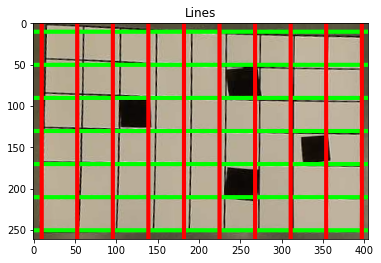

In [3]:
# be careful that if you have not called the previous sell, this will automatically set the missing values
nbAruco = 2
threshold = 170
calibrate = False
vision, Q_cam, R_cam, Q_gnd, R_gnd = cal_data.cam_calibration(calibrate, nbAruco, threshold)
if(DEBUG == True):
    print("Number of obstacles = ", np.count_nonzero(vision.grid))
    print(vision.grid)
    lines = vision.show()
    plt.figure
    plt.title('Lines')
    plt.imshow(cv2.cvtColor(lines.astype('uint8'), cv2.COLOR_BGR2RGB))


## Run code

Now that we have everything set up, we can run the code

In [ ]:
#######
# The following values have been set in the calibration part
# 
# Ts = 0.01
# SPPED_X = 101
# SPPED_0 = 100
# GND_THRESHOLD = 400
# If a preview is needed, run the following command
#
# print(f" The sampling time is : {Ts} s \n The speed is : {SPEED} mm/s \n The transition threshold is : {GND_THRESHOLD} \n")¨
# 
#######
#  The following values are the results of the calibration part 
#
# q_nu 
# r_nu
# conversion
# 
# print(f"The conversion factor for the speed of the thymio in mm/s is : {conversion} ")
# print(f"The standard deviation from the speed state (q_nu) and speed measurement (r_nu) is : {std_speed} ")
#######


In [ ]:
#test camera reliability
# for i in range(2):
#     vision.update_coordinates()
#     print("thymio position : ", vision.thymio_real_pos)
#     print("goal position : ", vision.goal_position)
#     aw(client.sleep(1))
corners,ids = vision.aruco()
print(len(ids))

thymio real pos :  [[334.30232558]
 [565.625     ]]
thymio pos in grid :  (2, 1)
goal pos :  (3, 3)
[[2 3 3 3]
 [1 1 2 3]]


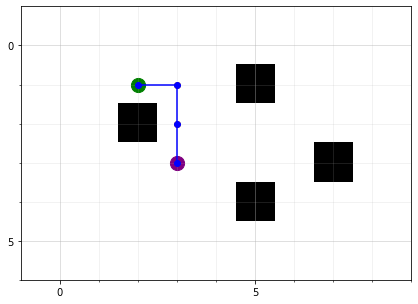

In [7]:
vision.update_coordinates()
if(DEBUG == True):
    print("thymio real pos : ", vision.thymio_real_pos)
    print("thymio pos in grid : ", vision.thymio_position)
    print("goal pos : ", vision.goal_position)
shortest_path = djikstra_algo(vision.grid.T, vision.thymio_position, vision.goal_position)
if(DEBUG == True):
    print(shortest_path)

KF = KalmanFilter(Ts, vision.thymio_real_pos, cal_data.speed_conversion, Q_cam, Q_gnd, R_cam, R_gnd)  # we initialize the filter

In [ ]:
print(vision.thymio_orientation)

In [ ]:
step_duration = 125 / (SPEED_X * cal_data.speed_conversion)
turn_duration = 98 / (SPEED_X * cal_data.speed_conversion)
vision.update_coordinates()
orientation = mc.correct_orientation(vision.thymio_orientation)
x = vision.thymio_position[0]
y = vision.thymio_position[1]
speed = np.array([SPEED_X+1, SPEED_Y])
turn_speed = np.array([0, 0])
#  A TOUT METTRE DANS MOTION CONTROL
jump = False
jump_x,jump_y = 0,0
kalmann_pos_x, kalmann_pos_y = 0,0
ajdust = 0
index = 0
for dx,dy in np.transpose(shortest_path):
    #est-ce quon actuallise les coords à partir de kalman ou de la caméra ? ou on laisse comme ca ?
    if jump:
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        index += 1
        if jump_x == dx and jump_y == dy:
            jump = False
        continue
    
    #faire une fonction de rotation pure
    vision.update_coordinates()  # camera_check()
    angle = vision.thymio_orientation # angle of the robot
    if((orientation == 0) & (angle > 270)):
        adjust_angle = angle - 360
    else:
        adjust_angle = angle - orientation*90 
    if(DEBUG == True):
        print("adjust angle before moving :", adjust_angle)
        
    if(adjust_angle > 0.00001):
        turn_speed[0] = int(SPEED_X*np.sign(adjust_angle))
        turn_speed[1] = int(-SPEED_Y*np.sign(adjust_angle))
        mc.motors(node, turn_speed[0], turn_speed[1])
        aw(client.sleep(5*abs(adjust_angle)//180)) # a changer pour un check sur time ?
        mc.motors(node, 0, 0)


    if False :#local_nav_error()
        jump_x,jump_y = 0,0#local_nav_correct(x,y,shortest_path)
    else:
        turn = mc.get_turn(dx-x,dy-y,orientation)
        orientation = orientation + turn
        mc.robot_turn(np.sign(turn),SPEED_X,cal_data.speed_conversion, node, client)    
        # si tout fonctionne à la fin, je vais essayer de modifié kalman pour inclure l'orientation, comme ca on enlève ce bout la
        if (((dx-x)!=0) | ((dy-y)!=0)):
            vision.update_coordinates()  #camera_check()
            angle = vision.thymio_orientation #angle of the robot
            if((orientation == 0) & (angle > 270)):
                adjust_angle = angle - 360
            else:
                adjust_angle = angle - orientation*90 
            if(DEBUG == True):
                print("adjust angle ", adjust_angle)
            if(adjust_angle > 0.00001):
                turn_speed[0] = int(SPEED_X*np.sign(adjust_angle))
                turn_speed[1] = int(-SPEED_Y*np.sign(adjust_angle))
                mc.motors(node, turn_speed[0], turn_speed[1])
                aw(client.sleep(5*abs(adjust_angle)//180))
                mc.motors(node, 0, 0)


            step_done = False
            speed = np.array([SPEED_X, SPEED_Y])
            start_move = time.time()
            mc.motors(node, speed[0], speed[1])
            temp = 0
            next_target_x = dx *CELL_WIDTH*2 + CELL_WIDTH
            next_target_y = dy *CELL_WIDTH*2 + CELL_WIDTH 

            while (temp < step_duration):
                vision.update_coordinates()
                kalman_pos= KF.filter(vision.isCamOn, vision.thymio_real_pos, orientation, speed, vision.thymio_orientation, 0, 0, GND_THRESHOLD)
                # kalman_pos = vision.thymio_real_pos
                delta_x = next_target_x - vision.thymio_real_pos
                delta_y = next_target_y - vision.thymio_real_pos
                desired_angle = np.tan(delta_y / delta_x)
                if(desired_angle)
                if(DEBUG == True):
                    print("estimated position ", kalman_pos)
                    print("position from camera ", vision.thymio_real_pos)
                adjust_turn,adjust_speed = mc.kalman_adjust(dx,dy,kalman_pos[0],kalman_pos[1],orientation, CELL_WIDTH)
                if(DEBUG == True):
                    print("les anciennes valeurs de speed sont :", speed)
                speed[0] = int(speed[0] + (-adjust_turn + adjust_speed)/50) #je reutilise juste les variables
                speed[1] = int(speed[1] + (adjust_turn + adjust_speed)/50) 
                print("speeds are :", speed)
                if(DEBUG == True):
                    print("les nouvelles valeurs de speed sont :", speed)
                mc.motors(node, speed[0], speed[1])
                current = time.time()
                temp = current - start_move
            mc.motors(node, 0, 0) 

            #
            #étape de correction entre l'estimation et le goal avant de passer à la step suivante
            #

    x = dx      #actualize the coordinates of the robot
    y = dy      #actualize the coordinates of the robot
    index += 1
    



In [ ]:

mc.motors(node, 0, 0)


In [ ]:
# step_duration = 125 / (SPEED_X * cal_data.speed_conversion)
# turn_duration = 98 / (SPEED_X * cal_data.speed_conversion)
# vision.update_coordinates()
# orientation = mc.correct_orientation(vision.thymio_orientation)
# x = vision.thymio_position[0]
# y = vision.thymio_position[1]
# speed = np.array([SPEED_X+1, SPEED_Y])
# turn_speed = np.array([0, 0])
# #  A TOUT METTRE DANS MOTION CONTROL
# jump = False
# jump_x,jump_y = 0,0
# kalmann_pos_x, kalmann_pos_y = 0,0
# ajdust = 0
# index = 0
# thymio_position = vision.thymio_real_pos
# for dx, dy in np.transpose(shortest_path):
#     next_target_x =  dx*125 + 62.5
#     next_target_y =  dy*125 + 62.5
#     delta_x = next_target_x - thymio_position[0]
#     delta_y = next_target_y - thymio_position[0]
#     desired_angle = np.tan(delta_y/ delta_x)
#     actual_angle = vision.thymio_orientation

#     #on fait une rotation pour corriger l'angle, on éxécute ca avec mc.motors et kalman



# for dx,dy in np.transpose(shortest_path):
#     #est-ce quon actuallise les coords à partir de kalman ou de la caméra ? ou on laisse comme ca ?
#     if jump:
#         x = dx      #actualize the coordinates of the robot
#         y = dy      #actualize the coordinates of the robot
#         index += 1
#         if jump_x == dx and jump_y == dy:
#             jump = False
#         continue
    
#     #faire une fonction de rotation pure
#     vision.update_coordinates()  # camera_check()
#     angle = vision.thymio_orientation # angle of the robot
#     if((orientation == 0) & (angle > 270)):
#         adjust_angle = angle - 360
#     else:
#         adjust_angle = angle - orientation*90 
#     if(DEBUG == True):
#         print("adjust angle before moving :", adjust_angle)
        
#     if(adjust_angle > 0.00001):
#         turn_speed[0] = int(SPEED_X*np.sign(adjust_angle))
#         turn_speed[1] = int(-SPEED_Y*np.sign(adjust_angle))
#         mc.motors(node, turn_speed[0], turn_speed[1])
#         aw(client.sleep(5*abs(adjust_angle)//180)) # a changer pour un check sur time ?
#         mc.motors(node, 0, 0)


#     if False :#local_nav_error()
#         jump_x,jump_y = 0,0#local_nav_correct(x,y,shortest_path)
#     else:
#         turn = mc.get_turn(dx-x,dy-y,orientation)
#         orientation = orientation + turn
#         mc.robot_turn(np.sign(turn),SPEED_X,cal_data.speed_conversion, node, client)    
#         # si tout fonctionne à la fin, je vais essayer de modifié kalman pour inclure l'orientation, comme ca on enlève ce bout la
#         if (((dx-x)!=0) | ((dy-y)!=0)):
#             vision.update_coordinates()  #camera_check()
#             angle = vision.thymio_orientation #angle of the robot
#             if((orientation == 0) & (angle > 270)):
#                 adjust_angle = angle - 360
#             else:
#                 adjust_angle = angle - orientation*90 
#             if(DEBUG == True):
#                 print("adjust angle ", adjust_angle)
#             if(adjust_angle > 0.00001):
#                 turn_speed[0] = int(SPEED_X*np.sign(adjust_angle))
#                 turn_speed[1] = int(-SPEED_Y*np.sign(adjust_angle))
#                 mc.motors(node, turn_speed[0], turn_speed[1])
#                 aw(client.sleep(5*abs(adjust_angle)//180))
#                 mc.motors(node, 0, 0)


#             step_done = False
#             speed = np.array([SPEED_X, SPEED_Y])
#             start_move = time.time()
#             mc.motors(node, speed[0], speed[1])

#             while ((current - start_move) > step_duration):
#                 vision.update_coordinates()
#                 # kalman_pos= KF.filter(vision.isCamOn, vision.thymio_real_pos, orientation, speed, vision.thymio_orientation, 0, 0, GND_THRESHOLD)
#                 kalman_pos = vision.thymio_real_pos
#                 # if(DEBUG == True):
#                 #     print("estimated position ", kalman_pos)
#                 #     print("position from camera ", vision.thymio_real_pos)
#                 # adjust_turn,adjust_speed = mc.kalman_adjust(dx,dy,kalman_pos[0],kalman_pos[1],orientation)
#                 # if(DEBUG == True):
#                 #     print("les anciennes valeurs de speed sont :", speed)
#                 # speed[0] = int(speed[0] - (adjust_turn + adjust_speed)/50) #je reutilise juste les variables
#                 # speed[1] = int(speed[1] + (adjust_turn - adjust_speed)/50) 
#                 print("speeds are :", speed)
#                 # if(DEBUG == True):
#                 #     print("les nouvelles valeurs de speed sont :", speed)
#                 # mc.motors(node, speed[0], speed[1])
#                 current = time.time()
#                 # if(): #peut-être changer pour une comparaison entre lestimation de position et le goal ?
#                     # step_done = True
#             mc.motors(node,0, 0) 

#             #
#             #étape de correction entre l'estimation et le goal avant de passer à la step suivante
#             #

#     x = dx      #actualize the coordinates of the robot
#     y = dy      #actualize the coordinates of the robot
#     index += 1
#     vision.cap.release()


In [ ]:
# step_duration = 125 / (SPEED_X * cal_data.speed_conversion)
# start = time.time()
# abc = False
# mc.motors(node, SPEED_X, SPEED_Y)
# temp = 0
# while(temp < step_duration):
#     current = time.time()
#     temp = current-start
mc.motors(node, 0, 0)

In [13]:
DEBUG = True



import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from kalmanfilter import KalmanFilter
import cv2   # a clean up
import Motion_control as mc
import local_nav as ln

#import computer_vision
from djikstra import djikstra_algo,create_plot
from calibration import data

### Connect the thymio(the speed set to 0 is here in case of an error during calibration or during the code)
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = aw(client.wait_for_node())
aw(node.lock())


#we initialize the calibration calss aswell as some values that are needed throughout the entire code
Ts = 0.01
SPEED_X = 101
SPEED_Y = 100
GND_THRESHOLD = 400

cal_data = data(Ts, SPEED_X, SPEED_Y, GND_THRESHOLD, client, node)
mc.motors(node, 0, 0)

In [ ]:
start1 = time.time()
i = 0
while(i < 5):
    i = i+1
    current1 = time.time()
    temp = start1-current1
    time.sleep(2)
    print(temp)

[[1 1 0 0 0 0 0 1 2 2]
 [1 2 2 3 4 5 6 6 6 7]]


ValueError: too many values to unpack (expected 2)

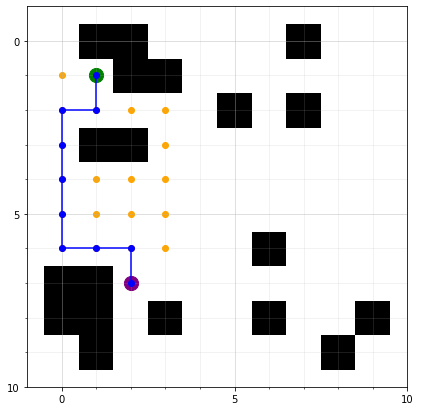

In [14]:
max_val_x = 10 # Size of the map
max_val_y = 10 # Size of the map
start = (1,1)
goal = (2,7)
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(max_val_x, max_val_y) * 20 # Create a grid of 50 x 50 random values
data = create_plot(max_val_x,max_val_y,data,start,goal)
shortest_path = djikstra_algo(data,start,goal)


jump = False
index = 0
x = start[0]
y = start[1]
speed = np.array([SPEED_X, SPEED_Y])
speed_conversion = 0.31
step_duration = 125 / (SPEED_X * speed_conversion)
turn_duration = 98 / (SPEED_X * speed_conversion)
orientation = 0
local = False
shortest_path = np.transpose(shortest_path)
print(shortest_path)
for dx,dy in shortest_path:
    if jump:
        x = dx      #actualize the coordinates of the robot
        y = dy      #actualize the coordinates of the robot
        index += 1
        if jump_x == dx and jump_y == dy:
            jump = False
        continue
    turn = mc.get_turn(dx-x,dy-y,orientation)
    orientation = orientation + turn
    for i in range(abs(turn)):
        mc.robot_turn(np.sign(turn),SPEED_X,speed_conversion, node, client)
    if (((dx-x)!=0) | ((dy-y)!=0)):
        local = ln.obstacle_detect(node)
        if local:
            print ("obstacle")
            jump,jump_x,jump_y,orientation = ln.obstacle_avoid(x,y,orientation, shortest_path[index+2][0], shortest_path[index+2][1], speed, step_duration, speed_conversion, node, client)
        else:
            start_move = time.time()
            step_done = False
            while (step_done == False):
                current = time.time()
                if((current - start_move) > step_duration): #peut-être changer pour une comparaison entre lestimation de position et le goal ?
                    step_done = True 
                else:   
                    speed[0] = int(speed[0]) #je reutilise juste les variables
                    speed[1] = int(speed[1]) 
                    mc.motors(node, speed[0], speed[1])
                    aw(client.sleep(Ts))
            mc.motors(node,0, 0)
            x = dx      #actualize the coordinates of the robot
            y = dy      #actualize the coordinates of the robot
            index += 1



In [ ]:
mc.motors(node, 0, 0)

We can see that the path has been properly computed. For the path's compution we needed the start and end point. As the kalman initialization also requires the starting point, we have decided to also initialize the filter at this point of the code.

changer pour du 
move
start = time.time()

vbla bla bla

current = time.time()
if current-start == temps pour la durée désirée

alors on passe à l'étape suivante





jouer avec la mesure de la vitesse sur la phase de calibration

